In [18]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.layers \
    import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.python.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from src.util.load_dataset import load_dataset
from src.util.plot_accuracy import plot_accuracy

# load and preprocess datasets
from src.util.plot_confusion_matrix import plot_confusion_matrix
train, x_train, y_train = load_dataset('../dataset/sign_mnist_train.csv')
test, x_test, y_test = load_dataset('../dataset/sign_mnist_test.csv')
y_true = test['label']

_, x_test_mir, y_text_mir \
    = load_dataset('../dataset/sign_mnist_test_mirsad.csv')
_, x_test_seb, y_test_seb \
    = load_dataset('../dataset/sign_mnist_test_sebastian.csv')
_, x_test_mar, y_test_mar \
    = load_dataset('../dataset/sign_mnist_test_mariia.csv')

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
data_generator = ImageDataGenerator(rotation_range=10,
                                    zoom_range=0.10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
save_plots = False

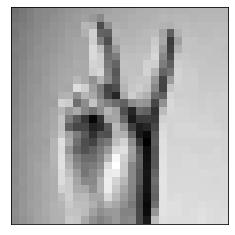

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


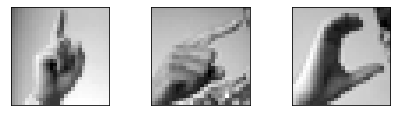

In [2]:
plt.tight_layout()
# plt.figure().set_size_inches(5, 5)
plt.imshow(x_train[21], cmap="gray")
axes = plt.gca()
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
if save_plots:
    plt.savefig('../plots/input_image.png',
                dpi=300,
                format='png',
                transparent=True,
                bbox_inches='tight')
plt.show()

# display first 3 images
train.head(3)


f, ax = plt.subplots(1, 3)
# f.set_size_inches(5, 10)

plt.tight_layout()

for i in range(3):
    ax[i].imshow(x_train[i], cmap="gray")
    print(y_train[i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
if save_plots:
    plt.savefig('../plots/input_first_three.png',
                dpi=300,
                format='png',
                transparent=True,
                bbox_inches='tight')

# print('unique values:', set(train['label'].values))
# print('min: {}, max: {}'.format(train['label'].values.min(),
#                                 train['label'].values.max()))

In [3]:
model = Sequential([
    # 2D convolution layer
    Conv2D(filters=32,  # number of neurons, found out through experiments
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='valid', # no padding
           activation='relu',
           input_shape=(28, 28, 1), # first layer in model
                                    # (height x width x channels)
           data_format='channels_last',
           name='input_layer'),
    # use max pooling since we want to extract the most salient features
    # rather than average features
    MaxPool2D(pool_size=(2, 2),
              strides=(2, 2),
              padding='valid', # no padding
              name='max_pool_1'),
    Dropout(rate=0.3,
            seed=None,
            name='dropout_1'),

    Conv2D(filters=64,
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           name='second_conv2D'),
    MaxPool2D(pool_size=(2, 2),
              strides=(2, 2),
              padding='valid',
              name='max_pool_2'),
    Dropout(rate=0.3,
            seed=None,
            name='dropout_2'),

    Flatten(name='flatten'),
    Dense(units=128, activation='relu', name='dense'),
    Dropout(rate=0.3,
            seed=None,
            name='dropout_3'),
    Dense(units=24,
          activation='softmax',
          name='output_layer')
])
model._name="Sign_MNIST_CNN"
model.summary() # print model summary
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print('model.submodules[0].input_shape:', model.submodules[0].input_shape)
# print('model.metrics_names:', model.metrics_names)

if save_plots:
    plot_model(model,
               to_file='../plots/model_plot.png',
               show_shapes=True,
               show_layer_names=False,
               rankdir='TB',
               dpi=200)

Model: "Sign_MNIST_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 24, 24, 32)        832       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
second_conv2D (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)           

In [4]:
# print(len(x_train))
# print(len(x_train[0]))

# if set to 0.2 that means that 20% of training data will be used in
# evaluation set
x_train2, x_val, y_train2, y_val = \
    train_test_split(x_train,
                     y_train,
                     test_size=0.2,
                     # random_state=42, # only for testing
                     # shuffle=False) # only for testing
                     )

In [5]:
# TRAINING

# without data augmentation
# history = model.fit(x_train2,
#                     y_train2,
#                     batch_size=64, # maybe change to 64!?
#                     epochs=10,
#                     validation_data=(x_val, y_val),
#                     callbacks=[annealer],
#                     verbose=1)

# with data augmentation
history = model.fit(data_generator.flow(x_train2, y_train2, batch_size=64),
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[annealer],
                    verbose=1)

print("\nTrain accuracy={}, Validation accuracy={}\n".format(
        max(history.history['accuracy']), max(history.history['val_accuracy'])))

# results = model.evaluate(x_test, y_test, verbose=1)
# results = model.evaluate(x_test_mirsad, y_test_mirsad, verbose=1)
results = model.evaluate(x_test_seb, y_test_seb, verbose=1)
# results = model.evaluate(x_test_mariia, y_test_mariia, verbose=1)
print("\ntest loss, test acc:", results)

Epoch 1/10
344/344 [==============================] - 5s 11ms/step - loss: 2.8758 - accuracy: 0.1332 - val_loss: 0.8708 - val_accuracy: 0.7649

In [6]:
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np
#
# img = Image.open("asl_a_cropped.jpg").resize((28, 28)).convert('LA')
# img = img.convert('P')
# img.save('greyscale.png')
# imgplot2 = plt.imshow(img)
#
# data = list(img.getdata()) # convert image data to a list of integers
# data = [pixel / 255 for pixel in data]
# data = np.array(data)
# data = data.reshape(-1,28, 28, 1)
#
# # print(data.shape)
# # print(data)
# # print(len(data))
# print(model.predict(data))
# print(np.argmax(model.predict(data)))

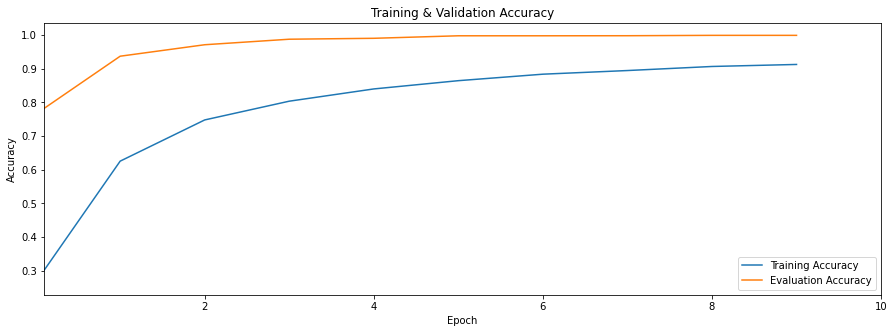

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      0.99      0.99       348
     Class 7       1.00      1.00      1.00       436
     Class 8       0.99      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

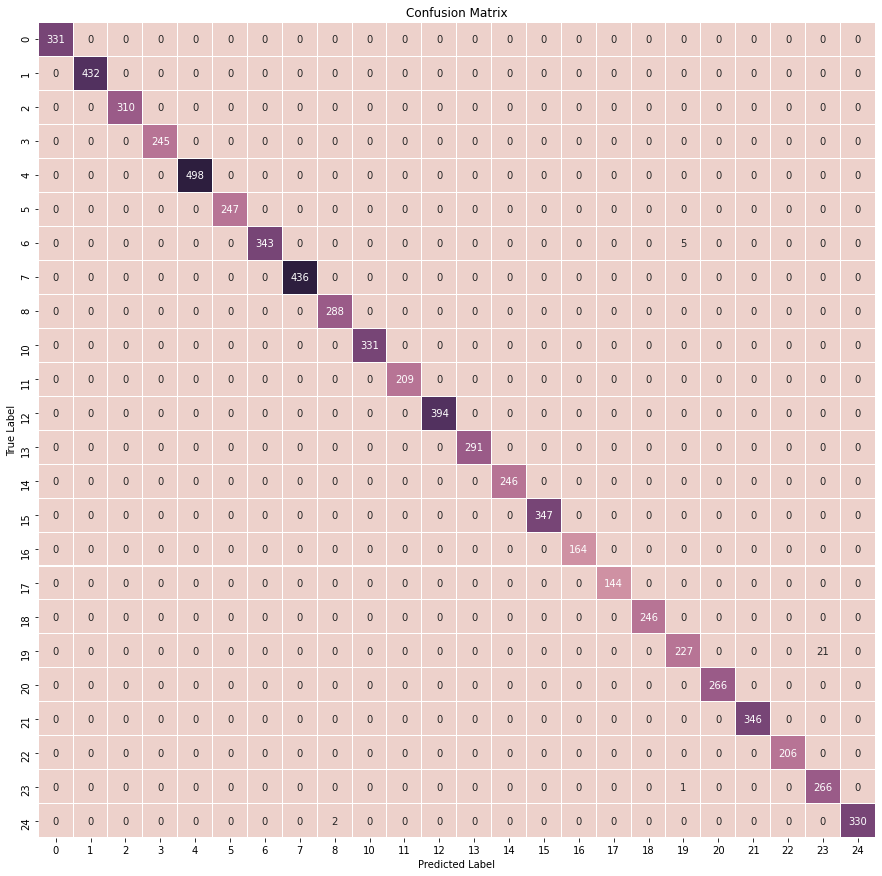

In [19]:
plot_accuracy(history)

y_pred = np.argmax(model.predict(x_test), axis=-1)

for i in range(len(y_pred)):
    if y_pred[i] >= 9:
        y_pred[i] += 1
classes = [i for i in range(25) if i != 9]
classes_names = ["Class " + str(i) for i in classes]
print(classification_report(y_true, y_pred, target_names=classes_names))

plot_confusion_matrix(y_true, y_pred, classes)

/home/sebastian/PycharmProjects/MLRobotics/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train Set')

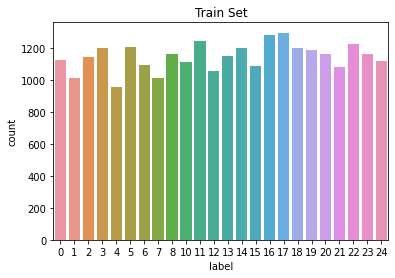

In [10]:
# move at the top to show that data is uniformly distributed

plt.figure()
sns.countplot(train['label']).set_title('Train Set')
